# Imports

In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import requests
import math
from PIL import Image
from io import BytesIO
from collections import Counter
from sklearn.model_selection import train_test_split


import wandb
from wandb.keras import WandbCallback

# Tensorflow imports

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Check if GPU/CPU is connected

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9142143735937025856
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10582238068731271192
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4973462816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14550676737130939743
physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:26:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11112266665877525185
physical_device_desc: "device: XLA_GPU device"
]


# Dataset exploration

Total number of categories: 150
Total number of images in dataset: 10841


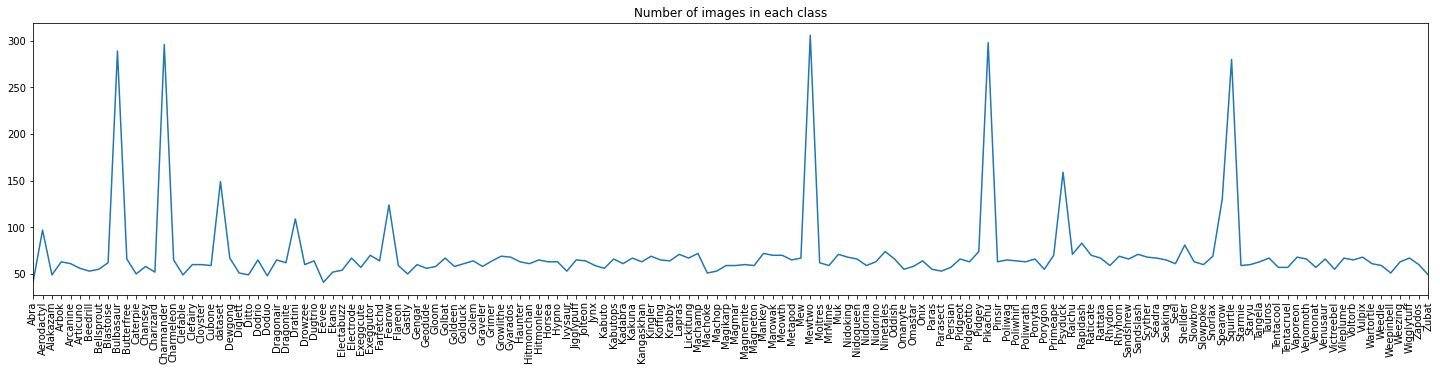

[('Mewtwo', 306), ('Pikachu', 298), ('Charmander', 296), ('Bulbasaur', 289), ('Squirtle', 280)]
['Mewtwo', 'Pikachu', 'Charmander', 'Bulbasaur', 'Squirtle']


In [4]:
# A little bit of data exploration
path = 'dataset/' # Path to directory which contains classes
classes = os.listdir(path) # List of all classes
print(f'Total number of categories: {len(classes)}')

# A dictionary which contains class and number of images in that class
counts = {}
for c in classes:
    counts[c] = len(os.listdir(os.path.join(path, c)))
    
print(f'Total number of images in dataset: {sum(list(counts.values()))}')

# Number of images in each clsss plot
fig = plt.figure(figsize = (25, 5))
sns.lineplot(x = list(counts.keys()), y = list(counts.values())).set_title('Number of images in each class')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()

# Sort our "counts" dictionary and selecting 5 classes with most number of images
imbalanced = sorted(counts.items(), key = lambda x: x[1], reverse = True)[:5]
print(imbalanced)

# Taking only labels, it will come in handy in future
imbalanced = [i[0] for i in imbalanced]
print(imbalanced)

In [5]:
X = [] # List for images
Y = [] # List for labels

# Loop through all classes
for c in classes:
    # We take only classes that we defined in 'imbalanced' list
    if c in imbalanced:
        dir_path = os.path.join(path, c)
        label = imbalanced.index(c) # Our label is an index of class in 'imbalanced' list
        
        # Reading, resizing and adding image and label to lists
        for i in os.listdir(dir_path):
            image = cv.imread(os.path.join(dir_path, i))
            
            try:
                resized = cv.resize(image, (96, 96)) # Resizing images to (96, 96)
                X.append(resized)
                Y.append(label)
            
            # If we can't read image - we skip it
            except:
                print(os.path.join(dir_path, i), '[ERROR] can\'t read the file')
                continue       
            
print('DONE')

DONE


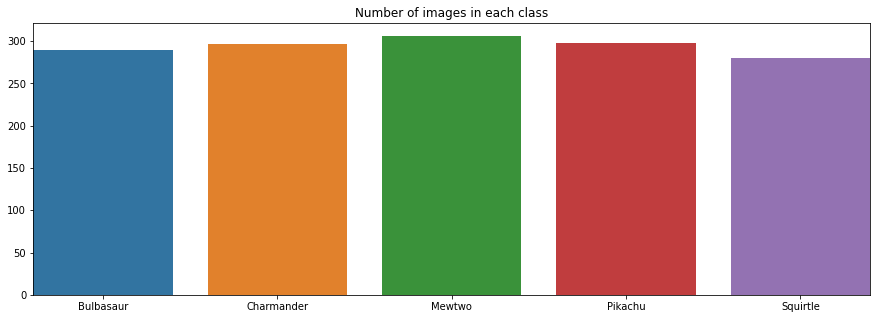

In [6]:
# Counting appearances of each label in labels list
obj = Counter(Y)

# Plotting number of images in each class
fig = plt.figure(figsize = (15, 5))
sns.barplot(x = [imbalanced[i] for i in obj.keys()], y = list(obj.values())).set_title('Number of images in each class')
plt.margins(x=0)
plt.show()

In [7]:
# Convert list with images to numpy array and reshape it 
X = np.array(X).reshape(-1, 96, 96, 3)

# Scaling data in array
X = X / 255.0

# Convert labels to categorical format
y = to_categorical(Y, num_classes = len(imbalanced))

# Splitting data to train and test datasets
# I'll use these datasets only for training, for final predictions I'll use random pictures from internet
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, shuffle = True, random_state = 666)

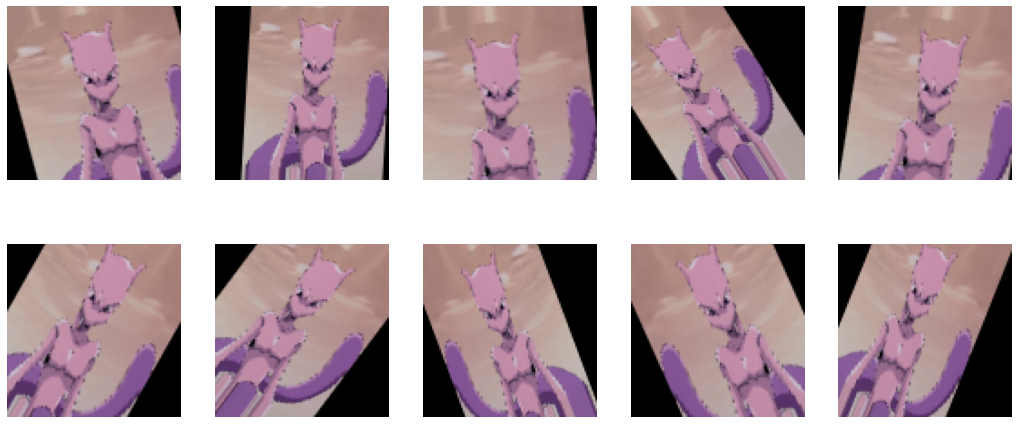

In [8]:
# Defining ImageDataGenerator Iinstance
datagen = ImageDataGenerator(rotation_range = 45, # Degree range for random rotations
                            zoom_range = 0.2, # Range for random zoom 
                            horizontal_flip = True, # Randomly flip inputs horizontally
                            width_shift_range = 0.15, # Range for horizontal shift 
                            height_shift_range = 0.15, # Range for vertical shift 
                            shear_range = 0.2,
                            ) # Shear Intensity

datagen.fit(X_train)

# This piece of code can be used if you eant to look what your datagen doing with your images
img = X[600]
img = img.reshape([-1, 96, 96, 3])

i = 0
fig = plt.figure(figsize = (18, 8))

for i, flow in enumerate(datagen.flow(img, batch_size = 1)):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(np.squeeze(flow[:, :, ::-1]))
    plt.axis('off')
    i += 1
    if i >= 10:
        break

# Define hyperparameters for sweep

In [9]:
sweep_config = {
  "name": "NN-zadanie2-test-sweep",
  "method": "random",
  "metric" : {
    'name': 'loss',
    'goal': 'minimize'   
    },
 "parameters" : {
    'optimizer': {
        'values': ['Adam', 'SGD', 'RMSprop','Adagrad']
        },

    'loss': {
        'values': ['categorical_crossentropy','poisson']
        },


    'learning_rate': {
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
        },

    'batch_size': {
        'distribution': 'q_log_uniform',
        'q': 1,
        'min': math.log(16),
        'max': math.log(64),
      },

    'epochs': {
        'distribution': 'int_uniform',
        'min':20,
        'max': 100,
        },
    'dropout_layers':{
       'values': [0.1, 0.25, 0.4, 0.5]
    },

    
    }   

}

In [15]:
wandb.init(project="NN-zadanie2")
sweep_id = wandb.sweep(sweep_config)

wandb: Currently logged in as: ramang (use `wandb login --relogin` to force relogin)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: gn4lhixs
Sweep URL: https://wandb.ai/ramang/uncategorized/sweeps/gn4lhixs


In [17]:
def getOpt(name,rl):

    if name ==  'Adam':
        return keras.optimizers.Adam(learning_rate=rl)
    elif name =='SGD':
        return keras.optimizers.SGD(learning_rate=rl)
    elif name =='RMSprop':
        return keras.optimizers.RMSprop(learning_rate=rl)
    else:
        return keras.optimizers.Adagrad(learning_rate=rl)

def train():
        with wandb.init(config=sweep_config):
        # Specify the other hyperparameters to the configuration
            config = wandb.config
            # Add the config item (layers) to wandb
            if wandb.run:
                # Define the model
                model = Sequential()
                model.add(Conv2D(32, 3, padding = 'same', activation = 'relu', input_shape =(96, 96, 3), kernel_initializer = 'he_normal'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((2, 2)))
                model.add(Dropout(0.25))

                model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                # model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                # model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((2, 2)))
                model.add(Dropout(0.25))

                model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                # model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                # model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((2, 2)))
                model.add(Dropout(0.25))

                model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                # model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                # model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((2, 2)))
                model.add(Dropout(0.25))

                model.add(Flatten())
                model.add(Dense(512, activation = 'relu'))
                model.add(BatchNormalization())
                model.add(Dropout(0.5))
                model.add(Dense(256, activation = 'relu'))
                model.add(BatchNormalization())
                model.add(Dropout(0.5))
                model.add(Dense(len(imbalanced), activation = 'softmax'))

                # model.summary()
                # callbacks
                checkpoint = ModelCheckpoint('../working/best_model_base.hdf5', verbose = 1, monitor = 'val_accuracy', save_best_only = True)
                earlyStoppingCallback = EarlyStopping(monitor='loss', patience=3)

                opt = getOpt(config.optimizer, config.learning_rate)
            
                model.compile(optimizer = opt, loss = config.loss, metrics = ['accuracy'])
                history = model.fit(
                    datagen.flow(X_train, y_train, batch_size = config.batch_size),
                    epochs = config.epochs,
                    validation_data = (X_test, y_test),steps_per_epoch=len(X_train) // config.batch_size, 
                    callbacks = [WandbCallback(),earlyStoppingCallback]
                    )   

In [12]:
# spustenie sweepu
# wandb.agent(sweep_id, function=train, count=5)

In [ ]:
model = Sequential()
model.add(Conv2D(32, 3, padding = 'same', activation = 'relu', input_shape =(96, 96, 3), kernel_initializer = 'he_normal'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(imbalanced), activation = 'softmax'))

# model.summary()

checkpoint = ModelCheckpoint('../working/best_model.hdf5', verbose = 1, monitor = 'val_accuracy', save_best_only = True)
earlyStoppingCallback = EarlyStopping(monitor='loss', patience=3)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(datagen.flow(X_train, y_train, batch_size = 16), epochs = 20, validation_data = (X_test, y_test),steps_per_epoch=len(X_train) // 16, callbacks = [checkpoint,earlyStoppingCallback])                             

Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 1.7502 - accuracy: 0.4418
Epoch 00001: val_accuracy improved from -inf to 0.55102, saving model to ../working\best_model.hdf5
73/73 [==============================] - 18s 245ms/step - loss: 1.7502 - accuracy: 0.4418 - val_loss: 1.5003 - val_accuracy: 0.5510
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 1.2382 - accuracy: 0.6316
Epoch 00002: val_accuracy did not improve from 0.55102
73/73 [==============================] - 17s 239ms/step - loss: 1.2382 - accuracy: 0.6316 - val_loss: 1.4804 - val_accuracy: 0.5442
Epoch 3/20
 1/73 [..............................] - ETA: 0s - loss: 1.2430 - accuracy: 0.6250

In [14]:
# # Plot learning curves
# fig = plt.figure(figsize = (17, 4))
    
# plt.subplot(121)
# plt.plot(history.history['accuracy'], label = 'acc')
# plt.plot(history.history['val_accuracy'], label = 'val_acc')
# plt.legend()
# plt.grid()
# plt.title(f'accuracy')

# plt.subplot(122)
# plt.plot(history.history['loss'], label = 'loss')
# plt.plot(history.history['val_loss'], label = 'val_loss')
# plt.legend()
# plt.grid()
# plt.title(f'loss')

